# Predicting Flight Delays

We have a large data set (7 million points) of flight arrivals in 2008. Can we predict how much a flight will be delayed before it takes off? Let's take a look.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import datetime

%matplotlib inline
sns.set_style('white')

In [2]:
raw_data = pd.read_csv('2008.csv').sample(frac=1)
len(raw_data)

7009728

In [3]:
data_clean = raw_data.reset_index(drop=True)
data_clean.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,8,25,1,1557.0,1600,1633.0,1640,AA,1685,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,6,11,3,1623.0,1625,1745.0,1751,NW,1559,...,6.0,14.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,7,10,4,2043.0,2040,2244.0,2245,WN,1669,...,2.0,11.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,5,25,7,611.0,615,709.0,710,AA,1256,...,5.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,3,24,1,1614.0,1610,1805.0,1802,DL,1484,...,11.0,23.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


First of all, I'm going to convert Year, Month, and DayofMonth to DayOfYear. This should capture holidays better than the features separately.

In [4]:
data_clean['DayOfYear'] = [datetime.datetime(
    data_clean.loc[row, 'Year'], 
    data_clean.loc[row, 'Month'], 
    data_clean.loc[row, 'DayofMonth']).timetuple().tm_yday for row in range(len(raw_data))]

In [5]:
data_clean['DayOfYear'].head()

0    238
1    163
2    192
3    146
4     84
Name: DayOfYear, dtype: int64

In [6]:
data_clean.drop(['Year', 'Month', 'DayofMonth'], axis=1, inplace=True)
data_clean.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,...,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DayOfYear
0,1,1557.0,1600,1633.0,1640,AA,1685,N555AA,96.0,100.0,...,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,238
1,3,1623.0,1625,1745.0,1751,NW,1559,N752NW,82.0,86.0,...,14.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,163
2,4,2043.0,2040,2244.0,2245,WN,1669,N522SW,61.0,65.0,...,11.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,192
3,7,611.0,615,709.0,710,AA,1256,N3AUAA,58.0,55.0,...,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,146
4,1,1614.0,1610,1805.0,1802,DL,1484,N669DN,111.0,112.0,...,23.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,84


In [7]:
data_clean.columns

Index(['DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode',
       'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'DayOfYear'],
      dtype='object')

What are we actually trying to predict with this data set? 

**Will a flight be at least 30 minutes late?**

The variable for this is "ArrDelay", and we'll have to convert it to binary.

Great, but that also means there's a lot of data in there that we can't actually use. Specifically, CarrierDelay through LateAircraftDelay are all a breakdown of WHY we're late. They contain the output variable, and can't be used predictively. Same with ArrTime, AirTime, TaxiIn, and ActualElapsedTime. Cancelled, Diverted, and TaxiOut are sketchy because they aren't known ahead of time. Similarly, DepDelay and DepTime are only known once the flight takes off. If our goal is to predict BEFORE a flight leaves the ground, then these are out as well. Let's see what we're left with.

In [8]:
data_clean.drop(['DepTime', 'ArrTime', 'ActualElapsedTime', 'AirTime', 
                 'DepDelay', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 
                 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
                 'LateAircraftDelay'], axis=1, inplace=True)

In [9]:
data_clean.columns

Index(['DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'CRSElapsedTime', 'ArrDelay', 'Origin', 'Dest', 'Distance',
       'DayOfYear'],
      dtype='object')

We should be able to safely dropna() now that most of the offending columns are gone.

In [10]:
data_clean.dropna(inplace=True)
data_clean.describe()

,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,ArrDelay,Distance,DayOfYear
count,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06,6.855024e+06
mean,3.925802e+00,1.325037e+03,1.493715e+03,2.212505e+03,1.290778e+02,8.168407e+00,7.287441e+02,1.796551e+02
std,1.988459e+00,4.643130e+02,4.826643e+02,1.956435e+03,6.953273e+01,3.850179e+01,5.632449e+02,1.039973e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-1.410000e+02,-5.190000e+02,1.100000e+01,1.000000e+00
25%,2.000000e+00,9.250000e+02,1.115000e+03,6.180000e+02,8.000000e+01,-1.000000e+01,3.260000e+02,9.100000e+01
50%,4.000000e+00,1.317000e+03,1.515000e+03,1.563000e+03,1.110000e+02,-2.000000e+00,5.810000e+02,1.780000e+02
75%,6.000000e+00,1.715000e+03,1.905000e+03,3.494000e+03,1.590000e+02,1.200000e+01,9.540000e+02,2.680000e+02
max,7.000000e+00,2.359000e+03,2.359000e+03,9.741000e+03,6.600000e+02,2.461000e+03,4.962000e+03,3.660000e+02


In [11]:
data_clean.shape

(6855024, 12)

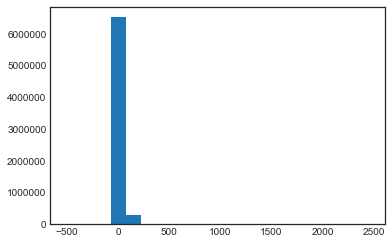

In [12]:
plt.hist(data_clean.ArrDelay, bins=20)
plt.show()

In [13]:
data_clean.ArrDelay.describe()

count    6.855024e+06
mean     8.168407e+00
std      3.850179e+01
min     -5.190000e+02
25%     -1.000000e+01
50%     -2.000000e+00
75%      1.200000e+01
max      2.461000e+03
Name: ArrDelay, dtype: float64

In [14]:
data_clean['IsLate'] = np.where(data_clean.ArrDelay>=30, 1, 0)
data_clean.IsLate.sum(), len(data_clean)

(927413, 6855024)

We'll be dealing with imbalanced classes here -- only about 13% of flights are delayed at least 30 minutes.

FlightNum and TailNum are categorical variables, so let's remove them for now. We're not going to make dummies for every single plane (although it might be interesting if we had the processing power).

In [15]:
data_clean.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

In [16]:
data_clean.UniqueCarrier.unique()

array(['AA', 'NW', 'WN', 'DL', 'US', 'EV', 'OO', 'MQ', 'F9', 'FL', 'YV',
       'XE', 'AS', 'UA', 'HA', '9E', 'B6', 'OH', 'CO', 'AQ'], dtype=object)

This one we can make dummies for. Also Origin and Dest (although this will give us a lot of features!). We'll be sure to run feature selection before we run our models.

In [17]:
data_clean = pd.get_dummies(data_clean)

In [18]:
from sklearn.utils import resample

In [19]:
# Data is already shuffled. Create Test Set and a Resampled Training Set.

test_frac = 0.05
test_size = int(test_frac*len(data_clean))

data_test = data_clean[:test_size]

data_train = data_clean[test_size:]
train_pos = data_train[data_train.IsLate==1]
train_neg = data_train[data_train.IsLate==0]
train_neg = resample(train_neg, n_samples=len(train_pos))
data_train = pd.concat([train_neg, train_pos]).sample(frac=1)

data_train.shape, data_test.shape

((1761564, 633), (342751, 633))

In [20]:
X_train = data_train.loc[:, ~data_train.columns.isin(['ArrDelay', 'IsLate'])]
Y_train = data_train['IsLate']

X_test = data_test.loc[:, ~data_test.columns.isin(['ArrDelay', 'IsLate'])]
Y_test = data_test['IsLate']

In [21]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFE

In [22]:
skb = SelectKBest(k=50)
skb.fit(X_train, Y_train)
X_train_skb = skb.transform(X_train)
X_test_skb = skb.transform(X_test)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [314] are constant.
  UserWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


In [24]:
lgr = LogisticRegression(penalty='l2')
lgr.fit(X_train_skb,Y_train)
print(lgr.score(X_test_skb,Y_test))
Y_pred = lgr.predict(X_test_skb)
confusion_matrix(Y_test, Y_pred)

0.615265892733


array([[182021, 114099],
       [ 17769,  28862]])

In [48]:
las = LogisticRegression(penalty='l1')
las.fit(X_train_skb,Y_train)
print(las.score(X_test_skb,Y_test))
Y_pred = las.predict(X_test_skb)
confusion_matrix(Y_test, Y_pred)

0.613025590149


array([[18183, 11473],
       [ 1789,  2826]])

In [59]:
knc = KNeighborsClassifier(n_neighbors=4)
knc.fit(X_train_skb,Y_train)
print(knc.score(X_test_skb,Y_test))
Y_pred = knc.predict(X_test_skb)
confusion_matrix(Y_test, Y_pred)

0.672346882204


array([[21105,  8551],
       [ 2678,  1937]])

In [50]:
dtc = DecisionTreeClassifier(max_depth=20, max_features=4)
dtc.fit(X_train_skb,Y_train)
print(dtc.score(X_test_skb,Y_test))
Y_pred = dtc.predict(X_test_skb)
confusion_matrix(Y_test, Y_pred)

0.575997198798


array([[16801, 12855],
       [ 1676,  2939]])

In [25]:
rfc = RandomForestClassifier(n_estimators=30, max_depth=20)
rfc.fit(X_train_skb,Y_train)
print(rfc.score(X_test_skb,Y_test))
Y_pred = rfc.predict(X_test_skb)
confusion_matrix(Y_test, Y_pred)

0.659315363048


array([[194898, 101222],
       [ 15548,  31083]])

In [52]:
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=3)
gbc.fit(X_train_skb,Y_train)
print(gbc.score(X_test_skb,Y_test))
Y_pred = gbc.predict(X_test_skb)
confusion_matrix(Y_test, Y_pred)

0.632954976511


array([[18606, 11050],
       [ 1529,  3086]])

In [ ]:
# This one takes a long time -- beware when using a large fraction of the data set!
svc = SVC(C=1)
svc.fit(X_train_skb,Y_train)
print(las.score(X_test_skb,Y_test))
Y_pred = las.predict(X_test_skb)
confusion_matrix(Y_test, Y_pred)

These classifiers are working okay -- KNeighbors actually seems to be working best, however we're still only predicting 2/3 of the late arrivals while misclassifying 3x as many negative examples as we are getting right.